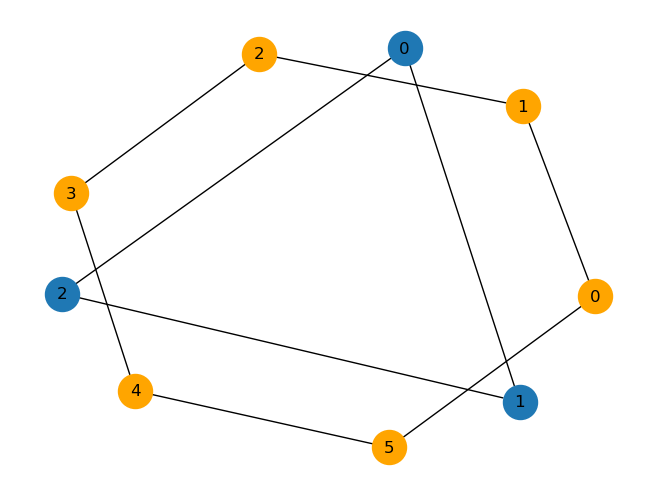

In [18]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

# FIRST EXAMPLE IN PAPER - G = 10-cycle, H = K_2 (max-cut)
# m = 10
# g = rx.PyGraph()
# g.add_nodes_from(np.arange(0, m, 1))
# e_g_list = [(0, 1, 1.0), (1, 2, 1.0), (2, 3, 1.0), (4, 5, 1.0), (5, 6, 1.0), (6, 7, 1.0), (7, 8, 1.0), (8, 9, 1.0), (9, 0, 1.0), (3, 6, 1.0), (4, 7, 1.0), (2, 8, 1.0), (0, 7, 1.0), (6, 8, 1.0)]
# g.add_edges_from(e_g_list)
# draw_graph(g, node_size=600, with_labels=True, node_color='orange')

# n = 2
# h = rx.PyGraph()
# h.add_nodes_from(np.arange(0, n, 1))
# e_h_list = [(0, 1, 1.0)]
# h.add_edges_from(e_h_list)
# #draw_graph(h, node_size=600, with_labels=True)

# SECOND EXAMPLE IN PAPER - G = 6-cycle, H = K_3 (max-3-cut)
m = 6
g = rx.PyGraph()
g.add_nodes_from(np.arange(0, m, 1))
e_g_list = [(0, 1, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 5, 1.0), (5, 0, 1.0)]
g.add_edges_from(e_g_list)
draw_graph(g, node_size=600, with_labels=True, node_color='orange')

n = 3
h = rx.PyGraph()
h.add_nodes_from(np.arange(0, n, 1))
e_h_list = [(0, 1, 1.0), (1, 2, 1.0), (0, 2, 1.0)]
h.add_edges_from(e_h_list)
draw_graph(h, node_size=600, with_labels=True)

In [19]:
e_g = np.zeros((m,m))
for edge in e_g_list:
    e_g[edge[0], edge[1]] = edge[2]
    e_g[edge[1], edge[0]] = edge[2]

e_h = np.zeros((n,n))
for edge in e_h_list:
    e_h[edge[0], edge[1]] = edge[2]
    e_h[edge[1], edge[0]] = edge[2]

print(e_g)
print(e_h)

[[0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1.]
 [1. 0. 0. 0. 1. 0.]]
[[0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 0.]]


In [20]:
def degree(graph, vertex):
    return np.sum(graph[vertex])

# Constructing Q
Q = np.zeros((m*n, m*n))
for i in range(m):
    for j in range(m):
        for u in range(n):
            for v in range(n):
                Q[i*n+u, j*n+v] = e_g[i, j] * e_h[u, v]

# Adding penalty for attempting to map input to multiple outputs
for i in range(m):
    start = i*n
    end = (i+1)*n
    for j in range(start, end):
        for k in range(start, end):
            if j != k:
                Q[j, k] -= degree(e_g, i) * degree(e_h, j - start) # penalty outweighs the highest possible reward for assigning an input to two outputs
print(Q)

[[ 0. -4. -4.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.]
 [-4.  0. -4.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.]
 [-4. -4.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.]
 [ 0.  1.  1.  0. -4. -4.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  1. -4.  0. -4.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  0. -4. -4.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  1.  0. -4. -4.  0.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  1. -4.  0. -4.  1.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.  0. -4. -4.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  1.  0. -4. -4.  0.  1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  1. -4.  0. -4.  1.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  1.  0. -4. -4.  0.  1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0. -4. -4.  0.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.

In [21]:
from qiskit.quantum_info import SparsePauliOp

# see https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm

pauli_list = []
for a in range(len(Q)):
    c = 0
    for b in range(len(Q[a])):
        if Q[a, b] != 0:
            paulis = ["I"] * len(Q)
            paulis[a], paulis[b] = "Z", "Z"
            weight = Q[a, b] # should always be 1 for now
            weight *= -1 # -weight to convert from minimizing problem to maximizing
            pauli_list.append(("".join(paulis), weight))

            c -= Q[a, b] + Q[b, a]
    paulis = ["I"] * len(Q)
    paulis[a] = "Z"
    pauli_list.append(("".join(paulis), -c)) # -c to convert from minimizing problem to maximizing
    
print(pauli_list)
cost_hamiltonian = SparsePauliOp.from_list(pauli_list)
print("Cost Function Hamiltonian:", cost_hamiltonian)

[('ZZIIIIIIIIIIIIIIII', np.float64(4.0)), ('ZIZIIIIIIIIIIIIIII', np.float64(4.0)), ('ZIIIZIIIIIIIIIIIII', np.float64(-1.0)), ('ZIIIIZIIIIIIIIIIII', np.float64(-1.0)), ('ZIIIIIIIIIIIIIIIZI', np.float64(-1.0)), ('ZIIIIIIIIIIIIIIIIZ', np.float64(-1.0)), ('ZIIIIIIIIIIIIIIIII', np.float64(-8.0)), ('ZZIIIIIIIIIIIIIIII', np.float64(4.0)), ('IZZIIIIIIIIIIIIIII', np.float64(4.0)), ('IZIZIIIIIIIIIIIIII', np.float64(-1.0)), ('IZIIIZIIIIIIIIIIII', np.float64(-1.0)), ('IZIIIIIIIIIIIIIZII', np.float64(-1.0)), ('IZIIIIIIIIIIIIIIIZ', np.float64(-1.0)), ('IZIIIIIIIIIIIIIIII', np.float64(-8.0)), ('ZIZIIIIIIIIIIIIIII', np.float64(4.0)), ('IZZIIIIIIIIIIIIIII', np.float64(4.0)), ('IIZZIIIIIIIIIIIIII', np.float64(-1.0)), ('IIZIZIIIIIIIIIIIII', np.float64(-1.0)), ('IIZIIIIIIIIIIIIZII', np.float64(-1.0)), ('IIZIIIIIIIIIIIIIZI', np.float64(-1.0)), ('IIZIIIIIIIIIIIIIII', np.float64(-8.0)), ('IZIZIIIIIIIIIIIIII', np.float64(-1.0)), ('IIZZIIIIIIIIIIIIII', np.float64(-1.0)), ('IIIZZIIIIIIIIIIIII', np.float64(4.0))

In [22]:
from qiskit.circuit.library import QAOAAnsatz

reps = 10
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=reps)
circuit.measure_all()

Below cell is not used unless running on IBM hardware

In [23]:
# from qiskit_ibm_runtime import QiskitRuntimeService
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# # QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
# service = QiskitRuntimeService(channel='ibm_quantum')
# backend = service.least_busy(min_num_qubits=127)
# print(backend)

# # Create pass manager for transpilation
# pm = generate_preset_pass_manager(optimization_level=3,
#                                     backend=backend)

# candidate_circuit = pm.run(circuit)
# candidate_circuit.draw('mpl', fold=False, idle_wires=False)

In [24]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator

backend = AerSimulator()
print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit = pm.run(circuit)

AerSimulator('aer_simulator')


In [25]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta] * reps

In [26]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)
    # print(cost) - for testing, print cost as optimizer runs

    return cost

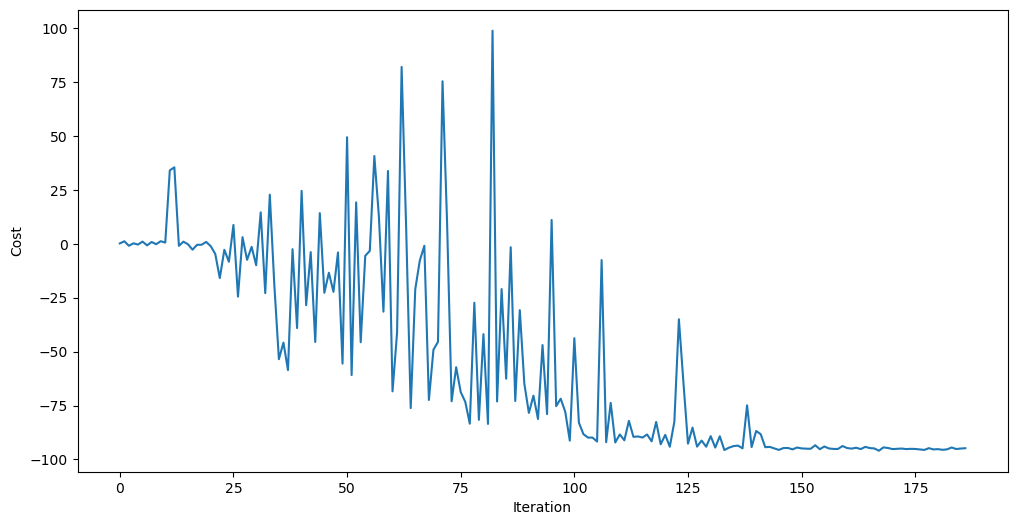

In [27]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize
import matplotlib.pyplot as plt

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    # estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    # estimator.options.dynamical_decoupling.enable = True
    # estimator.options.dynamical_decoupling.sequence_type = "XY4"
    # estimator.options.twirling.enable_gates = True
    # estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-3,
    )
    #print(result)

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [28]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
#optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [29]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Below code is only used for IBM hardware
# Set simple error suppression/mitigation options
# sampler.options.dynamical_decoupling.enable = True
# sampler.options.dynamical_decoupling.sequence_type = "XY4"
# sampler.options.twirling.enable_gates = True
# sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{70308: 0.0008, 140361: 0.0006, 82209: 0.0001, 49737: 0.0004, 135433: 0.0001, 71764: 0.0015, 150690: 0.0001, 49738: 0.0006, 140561: 0.0012, 82593: 0.0022, 157921: 0.0001, 70756: 0.0012, 141396: 0.0008, 139849: 0.0006, 33425: 0.0001, 38154: 0.001, 41737: 0.0009, 41428: 0.0001, 83044: 0.0016, 41508: 0.0001, 70546: 0.0001, 172819: 0.0001, 8842: 0.0004, 206994: 0.0001, 120097: 0.0001, 214089: 0.0001, 135948: 0.0011, 50337: 0.0005, 135817: 0.0005, 140370: 0.0007, 42148: 0.0008, 137346: 0.0002, 136332: 0.001, 83209: 0.0011, 136274: 0.0009, 71820: 0.0019, 32905: 0.0002, 139860: 0.0007, 41767: 0.0001, 74505: 0.0008, 42260: 0.0013, 148234: 0.0014, 59537: 0.0001, 43106: 0.0015, 50450: 0.0016, 70666: 0.0001, 205389: 0.0001, 143458: 0.0001, 75876: 0.0007, 70305: 0.0007, 70804: 0.0007, 135940: 0.0001, 4770: 0.0001, 173321: 0.0001, 42209: 0.0001, 5412: 0.0003, 50465: 0.0007, 4769: 0.0003, 97718: 0.0001, 137480: 0.0001, 51297: 0.0004, 140066: 0.0007, 83020: 0.0015, 140352: 0.0002, 86001: 0.0001, 7877

In [34]:
top_n = 15

def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = [(keys[i], values[i]) for i in np.argsort(np.abs(values))][:-top_n-1:-1]
most_likely_bitstring = [(to_bitstring(key, len(Q))[::-1], value) for (key, value) in most_likely]

for bit_string in most_likely_bitstring:
    print("Bitstring: ", bit_string)

Bitstring:  ([0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0], 0.0023)
Bitstring:  ([0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0], 0.0022)
Bitstring:  ([1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0], 0.0022)
Bitstring:  ([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0], 0.0021)
Bitstring:  ([0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0], 0.0021)
Bitstring:  ([0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0], 0.002)
Bitstring:  ([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0], 0.002)
Bitstring:  ([0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0], 0.002)
Bitstring:  ([0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1], 0.002)
Bitstring:  ([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1], 0.002)
Bitstring:  ([1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1], 0.0019)
Bitstring:  ([0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0], 0.0019)
Bitstring:  ([0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0], 0.0019)
Bits

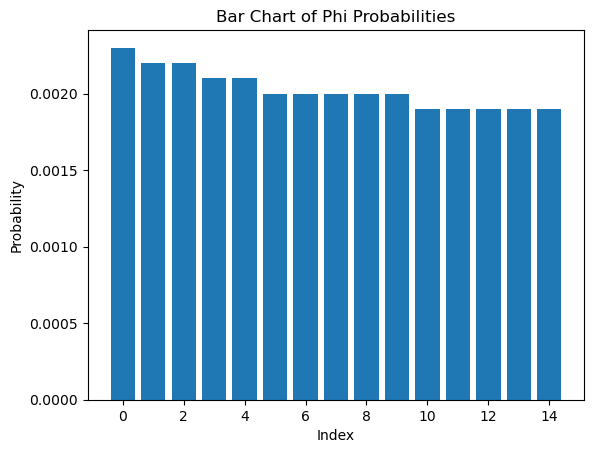


Index 0:
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]

Index 1:
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]

Index 2:
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]

Index 3:
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]

Index 4:
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]

Index 5:
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]

Index 6:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]

Index 7:
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]

Index 8:
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]

Index 9:
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]

Index 10:
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]

Index 11:
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]

I

In [35]:
most_likely_key_only = [key for (key, value) in most_likely_bitstring]
most_likely_value_only = [value for (key, value) in most_likely_bitstring]

plt.bar(range(len(most_likely_value_only)), most_likely_value_only)

# Add labels
plt.xlabel("Index")
plt.ylabel("Probability")
plt.title("Bar Chart of Phi Probabilities")
plt.show()

hom = np.zeros((top_n, m, n))
for k in range(top_n):
    for i in range(m):
        for j in range(n):
            hom[k][i, j] = most_likely_key_only[k][i*n + j]
    print(f"\nIndex {k}:")
    print(hom[k])

In [36]:
def first_nonzero(array):
    for i in range(len(array)):
        if array[i] != 0:
            return i
    return None

def edge_in_graph(g, tup):
    if tup == None:
        return 0
    return g[tup[0]][tup[1]]

def edge_across_hom(hom, v1, v2):
    if first_nonzero(hom[v1]) == None or first_nonzero(hom[v2]) == None:
        return None
    return (first_nonzero(hom[v1]), first_nonzero(hom[v2]))

print(f'G:\n{e_g}')
print(f'H:\n{e_h}')

max = 0
max_index = 0
for h in range(len(hom)):
    total = 0
    for i in range(m):
        for j in range(m):
            term = edge_in_graph(e_g, (i,j)) * edge_in_graph(e_h, edge_across_hom(hom[h], i, j))
            total += term
            if term == 1 and h == 1:
                #print(f'Edge in G: ({i}, {j}), edge in H: ({edge_across_hom(hom[h], i, j)})')
                pass
            if i == 2 and j == 3:
                #print(f'(2, 3) Edge in H: ({edge_across_hom(hom[h], i, j)})')
                pass
    print(f'Value: {total}')
    if total > max:
        max = total
        max_index = h

print(f'Best hom ({max // 2}):\n{hom[max_index]}')

G:
[[0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1.]
 [1. 0. 0. 0. 1. 0.]]
H:
[[0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 0.]]
Value: 12.0
Value: 12.0
Value: 12.0
Value: 12.0
Value: 12.0
Value: 12.0
Value: 12.0
Value: 10.0
Value: 12.0
Value: 12.0
Value: 10.0
Value: 12.0
Value: 12.0
Value: 10.0
Value: 12.0
Best hom (6.0):
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
